# 04wk-2: (신경망) – 꺽인그래프의 한계(?), 시벤코정리, MNIST

최규빈  
2025-03-31

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/04wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [2]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-wD7Am2wZ7NNZjHpt55gwEH&si=Yj3LYi8Y9uU5SYtp >}}

# 2. Imports

In [21]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import torchvision
# import fastai.data.all 

# 3. 꺽인그래프의 한계?

`-` 걱정: 지난시간에 배운 기술은 sig를 취하기 전이 꺽은선인 형태만
가능할 듯 하다. 그래서 이 역시 표현력이 부족할 듯 하다.

`-` 그런데 생각보다 표현력이 풍부한 편이다. 즉 생각보다 쓸 만하다.

## A. Step은 표현 불가능하지 않나?

`# 예제1` – 일부러 이상하게 만든 취업합격률 곡선

In [95]:
torch.manual_seed(43052)
x = torch.linspace(-1,1,2000).reshape(-1,1)
u = 0*x-3
u[x<-0.2] = (15*x+6)[x<-0.2]
u[(-0.2<x)&(x<0.4)] = (0*x-1)[(-0.2<x)&(x<0.4)]
sig = torch.nn.Sigmoid()
v = π = sig(u)
y = torch.bernoulli(v)

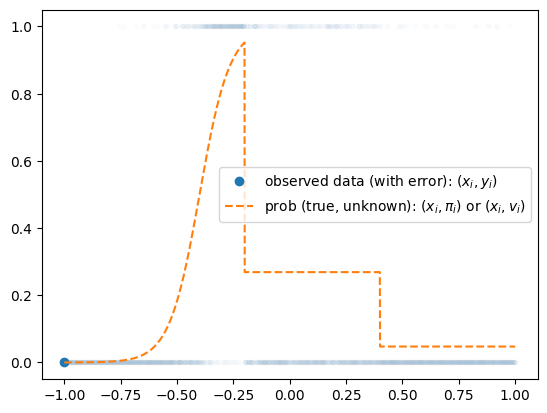

In [96]:
#plt.plot(u,alpha=0.2)
plt.plot(x,y,'.',alpha=0.01,color="C0")
plt.plot(x[0],y[0],'o',color="C0",label=r"observed data (with error): $(x_i,y_i)$")
plt.plot(x,v,'--',label=r"prob (true, unknown): $(x_i,\pi_i)$ or $(x_i,v_i)$",color="C1")
plt.legend()

`-` 저 주황색 구조를 어떻게 표현하지? $\to$ 선이 많이 꺽이면되는거아냐?

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,256)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,256)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

In [97]:
#torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,1),
    #torch.nn.Sigmoid()
)
#loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

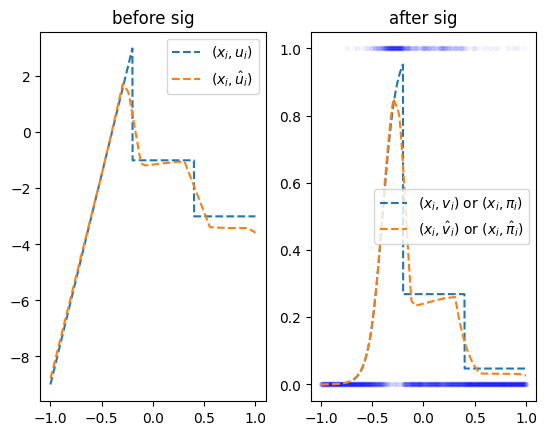

In [98]:
fig,ax = plt.subplots(1,2)
ax[0].plot(x,u,'--',label=r"$(x_i,u_i)$")
ax[0].plot(x,yhat.data,'--',label=r"$(x_i,\hat{u}_i)$")
ax[0].legend()
ax[0].set_title("before sig")
ax[1].plot(x,y,'.',alpha=0.02,color="blue")
ax[1].plot(x,v,'--', color="C0", label=r"$(x_i,v_i)$ or $(x_i,\pi_i)$")
ax[1].plot(x,sig(yhat.data),'--',color="C1",label=r"$(x_i,\hat{v}_i)$ or $(x_i,\hat{\pi}_i)$")
ax[1].legend()
ax[1].set_title("after sig")

`#`

## B. 곡선은 표현 불가능하지 않나?

`# 예제2` – 2024년 수능 미적30번 문제에 나온 곡선

$$y_i = e^{-x_i} \times  |\cos(5x_i)| \times \sin(5x) + \epsilon_i, \quad \epsilon_i \sim N(0,\sigma^2)$$

In [99]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

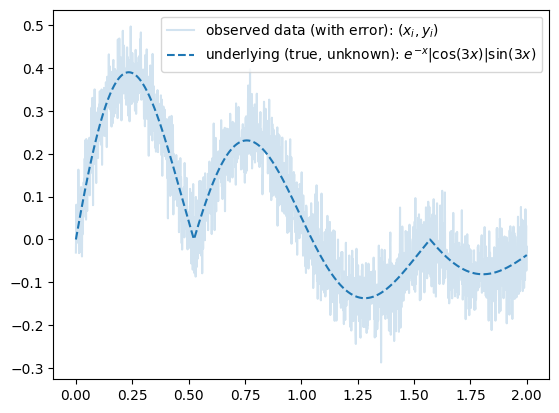

In [100]:
plt.plot(x,y,label=r"observed data (with error): $(x_i,y_i)$", alpha=0.2)
plt.plot(x,fx,'--',color="C0",label=r"underlying (true, unknown): $e^{-x}|\cos(3x)|\sin(3x)$")
plt.legend()

`-` 맞춰본다..

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,1024)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,1024)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [101]:
#torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

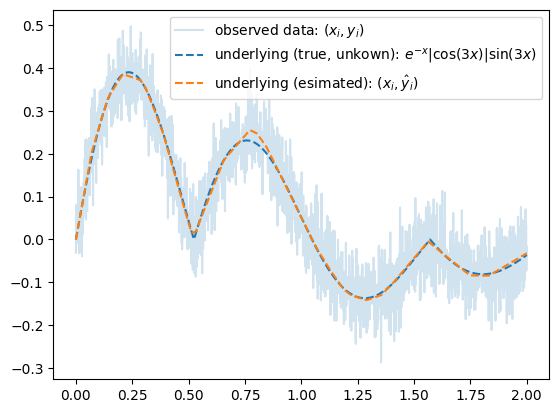

In [102]:
plt.plot(x,y,label=r"observed data: $(x_i,y_i)$", alpha=0.2)
plt.plot(x,fx,'--',color="C0",label=r"underlying (true, unkown): $e^{-x}|\cos(3x)|\sin(3x)$")
plt.plot(x,yhat.data,'--',color="C1",label=r"underlying (esimated): $(x_i,\hat{y}_i)$")
plt.legend()

`#`

# 4. 시벤코정리

## A. 시벤코의 정리 소개

> **Universal Approximation Thm Goodfellow, Bengio, and Courville
> (2016)**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크
> $net: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$는
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),
>     torch.nn.Linear(???,q)
> )
> ```
>
> 모든 보렐 가측함수 (Borel measurable function)
>
> $$f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$$
>
> 를 원하는 정확도로 “근사”시킬 수 있다. 쉽게 말하면
> ${\bf X} \to {\bf y}$ 인 어떠한 복잡한 규칙라도 하나의 은닉층을 가진
> 신경망이 원하는 정확도로 근사시킨다는 의미이다. 예를들면 아래와 같은
> 문제를 해결할 수 있다.
>
> -   ${\bf X}$는 토익점수, GPA, 공모전참가여부, ${\bf y}$는 취업여부일
>     경우 ${\bf X} \to {\bf y}$인 규칙을 심층신경망은 항상 찾을 수
>     있다.
> -   ${\bf X}$는 주택이미지, 지역정보, 주택면적, 주택에 대한 설명
>     ${\bf y}$는 주택가격일 경우 ${\bf X} \to {\bf y}$인 규칙을
>     심층신경망은 항상 찾을 수 있다.
>
> 즉 하나의 은닉층을 가진 신경망의 표현력은 거의 무한대라 볼 수 있다.

## B. 왜 가능한가?

`-` 데이터

In [10]:
x = torch.linspace(-10,10,200).reshape(-1,1)

`-` 아래와 같은 네트워크를 고려하자. (스펙올라도 취업못하는 예제에서
썼던 네크워크랑 비슷해요)

In [11]:
l1 = torch.nn.Linear(in_features=1,out_features=2)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=2,out_features=1)

`-` 직관1: $l_1$,$l_2$의 가중치를 잘 결합하다보면 우연히 아래와 같이
만들 수 있다.

In [12]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+10.00,+10.00])

In [13]:
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])

<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_31460/3092854458.py:8: SyntaxWarning: invalid escape sequence '\c'
  ax[1].set_title('$(a_1 \circ l_1)(x)$')
/tmp/ipykernel_31460/3092854458.py:11: SyntaxWarning: invalid escape sequence '\c'
  ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$')

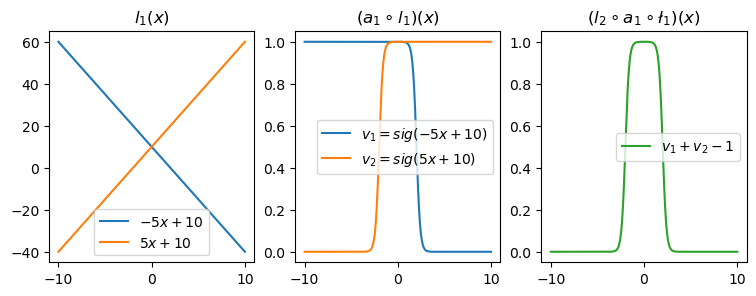

In [14]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x)[:,[0]].data,label=r"$-5x+10$")
ax[0].plot(x,l1(x)[:,[1]].data,label=r"$5x+10$")
ax[0].set_title('$l_1(x)$')
ax[0].legend()
ax[1].plot(x,a1(l1(x))[:,[0]].data,label=r"$v_1=sig(-5x+10)$")
ax[1].plot(x,a1(l1(x))[:,[1]].data,label=r"$v_2=sig(5x+10)$")
ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[1].legend()
ax[2].plot(x,l2(a1(l1(x))).data,color='C2',label=r"$v_1+v_2-1$")
ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$')
ax[2].legend()

`-` 직관2: 아래들도 가능할듯?

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_31460/3368460049.py:7: SyntaxWarning: invalid escape sequence '\c'
  ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C0'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
/tmp/ipykernel_31460/3368460049.py:8: SyntaxWarning: invalid escape sequence '\c'
  ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C0'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');

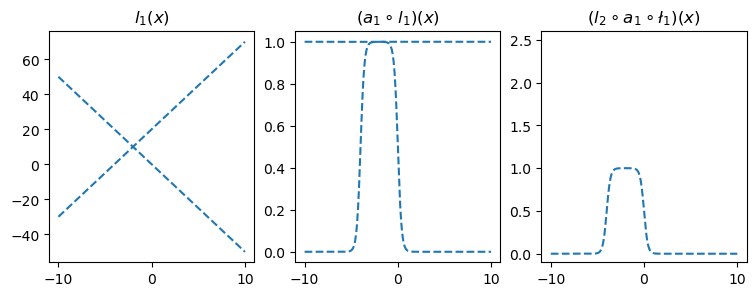

In [15]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+0.00,+20.00])
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data.numpy(),'--',color='C0'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C0'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C0'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
ax[2].set_ylim(-0.1,2.6)

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_31460/2330299143.py:7: SyntaxWarning: invalid escape sequence '\c'
  ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C1'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
/tmp/ipykernel_31460/2330299143.py:8: SyntaxWarning: invalid escape sequence '\c'
  ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C1'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');

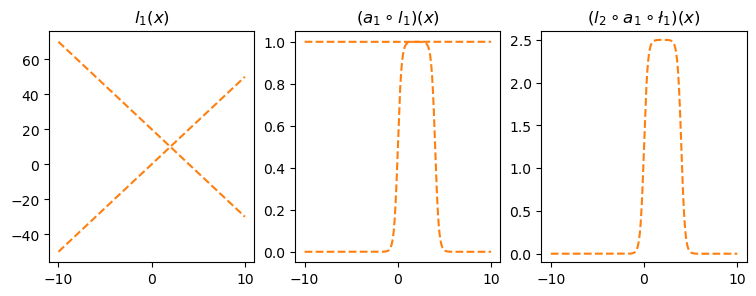

In [16]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+20.00,+00.00])
l2.weight.data = torch.tensor([[2.50,2.50]])
l2.bias.data = torch.tensor([-2.50])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data.numpy(),'--',color='C1'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data.numpy(),'--',color='C1'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C1'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
ax[2].set_ylim(-0.1,2.6)

`-` 직관3: `은닉층의노드수=4`로 하고 적당한 가중치를 조정하면
$(l_2\circ a_1 \circ l_1)(x)$의 결과로 주황색선 + 파란색선도 가능할 것
같다. $\to$ 실제로 가능함

In [17]:
l1 = torch.nn.Linear(in_features=1,out_features=4)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=4,out_features=1)

In [18]:
l1.weight.data = torch.tensor([[-5.00],[5.00],[-5.00],[5.00]])
l1.bias.data = torch.tensor([0.00, 20.00, 20.00, 0])
l2.weight.data = torch.tensor([[1.00,  1.00, 2.50,  2.50]])
l2.bias.data = torch.tensor([-1.0-2.5])

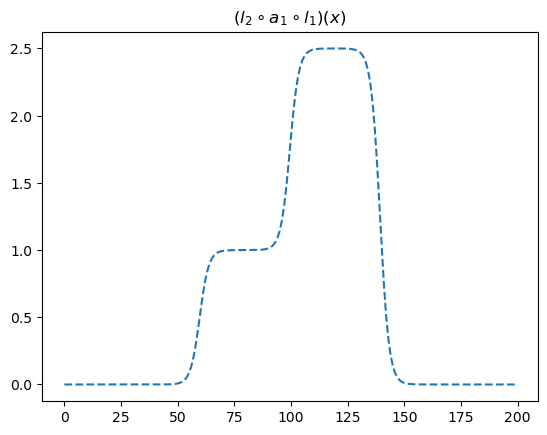

In [19]:
plt.plot(l2(a1(l1(x))).data,'--')
plt.title(r"$(l_2 \circ a_1 \circ l_1)(x)$")

> 이러한 함수는 계단모양이며, 0을 제외한 서로다른 계단의 높이는 2개가
> 된다. 이를 간단히 “2단계-계단함수”라고 칭하자.

`-` 정리1: 2개의 시그모이드를 우연히 잘 결합하면 아래와 같은
“1단계-계단함수” 함수 $h$를 만들 수 있다.

In [20]:
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0

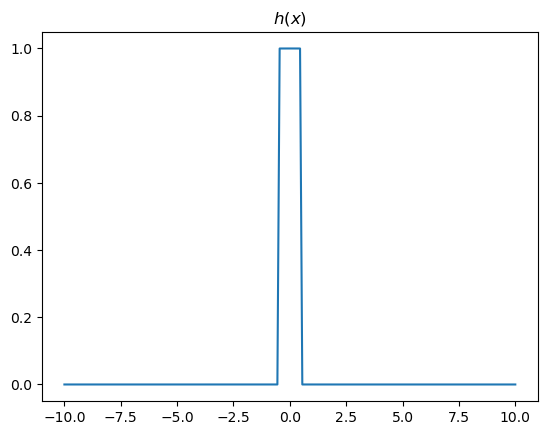

In [21]:
plt.plot(x,h(x))
plt.title("$h(x)$")

`-` 정리2: 위와 같은 함수 $h$를 활성화함수로 하고 $m$개의 노드를 가지는
은닉층을 생각해보자. 이러한 은닉층을 사용한다면 “m단계-계단함수”와 같은
형태의 네트워크는 아래와 같이 $m$개의 은닉노드를 써서 항상 표현할 수
있다.

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

그리고 위의 네트워크와 동일한 효과를 주는 아래의 네트워크가 항상 존재함.

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,2m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` 직관4: 그런데 어떠한 함수형태라도 구불구불한 “m단계-계단함수”로 다
근사할 수 있지 않나?

## C. $h$의 위력

`-` $h(x)$를 생성하는 클래스를 만들어보자.

In [22]:
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__()
    def forward(self, u):
        h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
        v = h(u)
        return v # activation 의 출력

In [23]:
a1 = MyActivation()
# a1 = torch.nn.Sigmoid(), a1 = torch.nn.ReLU() 대신에 a1 = MyActivation()

`-` 아래와 같이 하나의 은닉층을 가지고 있더라도 많은 노드수만 보장되면
매우 충분한 표현력을 가짐

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` $h$의 위력을 체감해보자.

`# 예제1` – 스펙의 역설

In [103]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2025/main/posts/ironyofspec.csv")
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

In [104]:
torch.manual_seed(43052)
class MyActivation(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, u):
        h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
        v = h(u)
        return v
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    MyActivation(),
    torch.nn.Linear(2048,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(100):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

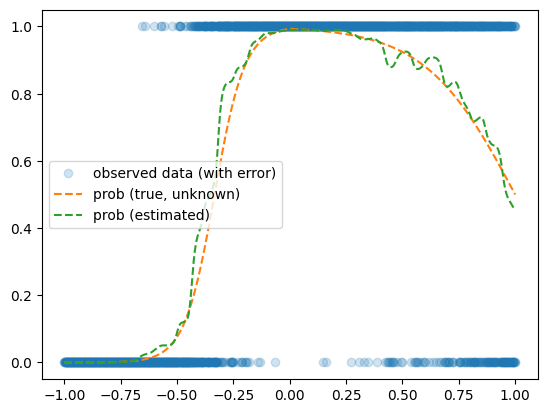

In [105]:
plt.plot(x,y,'o',alpha=0.2, label="observed data (with error)")
plt.plot(x,prob,'--', label="prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated)")
plt.legend()

`#`

`# 예제2` – 수능곡선

In [106]:
torch.manual_seed(43052)
x = torch.linspace(0,2,2000).reshape(-1,1)
eps = torch.randn(2000).reshape(-1,1)*0.05
fx = torch.exp(-1*x)* torch.abs(torch.cos(3*x))*(torch.sin(3*x))
y = fx + eps

In [107]:
torch.manual_seed(43052)
class MyActivation(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, u):
        h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
        v = h(u)
        return v
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    MyActivation(),
    torch.nn.Linear(2048,1),
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(100):
    ## 1
    yhat = net(x)
    ## 2
    loss = loss_fn(yhat,y)
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

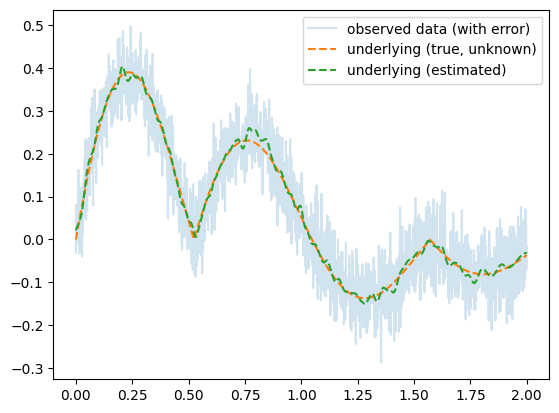

In [108]:
plt.plot(x,y,alpha=0.2,label="observed data (with error)")
plt.plot(x,fx,'--',label="underlying (true, unknown)")
plt.plot(x,net(x).data,'--',label="underlying (estimated)")
plt.legend()

`#`

## D. 의문점

`-` 이 수업을 잘 이해한 사람: 그냥 활성화함수를 $h$로 쓰면 끝 아니야?
뭐하러 relu 를 쓰는거지?

`-` 딥러닝을 좀 공부해본사람1: 왜 딥러닝이 2010년이 지나서야 떳지?
1989년에 세상의 모든 문제가 풀려야 하는것 아닌가?

`-` 딥러닝을 좀 공부해본사람2: 하나의 은닉층을 가진 네크워크는 잘 안쓰지
않나? 은닉층이 깊을수록 좋다고 들었는데?

`-` 약간의 의구심이 있지만 아무튼 우리는 아래의 무기를 가진 꼴이 되었다.

> **우리의 무기**
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크로,
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(),
>     torch.nn.Linear(???,q)
> )
> ```
>
> $f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$ 인 모든 보렐 가측
> 함수 $f$ 을 원하는 정확도로 “근사”시킬 수 있다.

# 5. MNIST 해결

## A. 예비학습 – \``plt.imshow()`

`-` `plt.imshow(...)` 에서 `...`이 shape이 (??,??)이면 흑백이미지를 출력

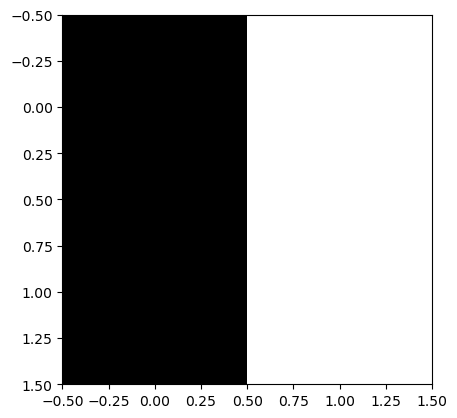

In [37]:
plt.imshow([[0,255],[0,255]],cmap='gray')

`-` `plt.imshow(...)` 에서 `...`의 shape이 (??,??,3)이면 칼라이미지를
출력

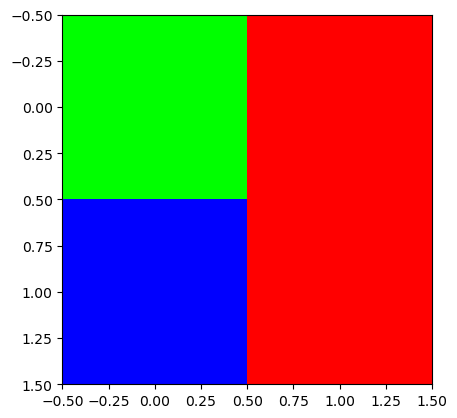

In [38]:
r = [[0,255],[0,255]]
g = [[255,0],[0,0]]
b = [[0,0],[255,0]]
plt.imshow(np.stack([r,g,b],axis=2))

`-` `plt.imshow(...)` 에서 `...`의 자료형이 int인지 float인지에 따라서
인식이 다름

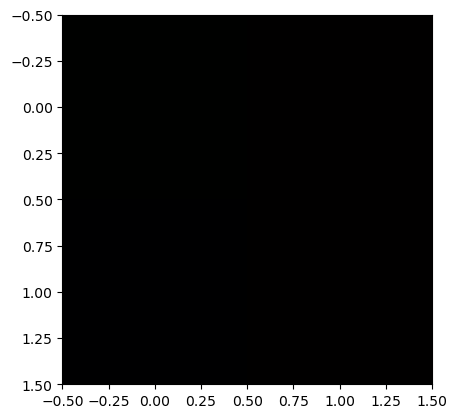

In [39]:
r = [[0,1],[0,1]]
g = [[1,0],[0,0]]
b = [[0,0],[1,0]]
plt.imshow(np.stack([r,g,b],axis=2))

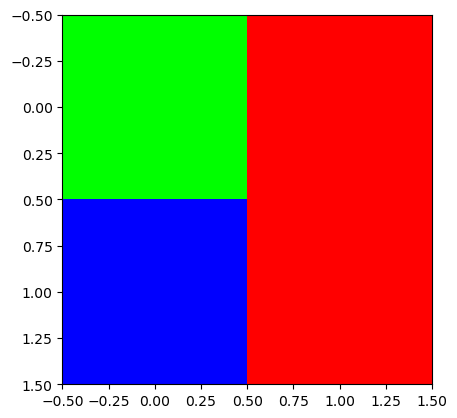

In [40]:
r = [[0,1.0],[0,1.0]]
g = [[1.0,0],[0,0]]
b = [[0,0],[1.0,0]]
plt.imshow(np.stack([r,g,b],axis=2))

## B. 데이터

`-` 데이터 정리코드

In [62]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)
to_tensor = torchvision.transforms.ToTensor()
X3 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==3])
X7 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==7])
X = torch.concat([X3,X7],axis=0)
y = torch.tensor([0.0]*len(X3) + [1.0]*len(X7))

In [63]:
X.shape, y.shape

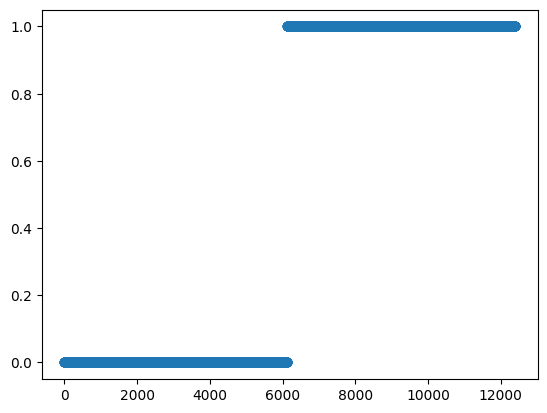

In [64]:
plt.plot(y,'o')

-   “y=0.0” 은 숫자3을 의미함, “y=1.0” 은 숫자7을 의미함
-   숫자3은 6131개, 숫자7은 6265개 있음

`-` 우리는 ${\bf X}: (n,1,28,28)$ 에서 ${\bf y}: (n,1)$으로 가는 맵핑을
배우고 싶음. $\to$ 이런건 배운적이 없는데?.. $\to$ 그렇다면
${\bf X}:(n,784) \to {\bf y}:(n,1)$ 으로 가는 맵핑을 학습하자.

In [65]:
X = torch.stack([xi.reshape(-1) for xi in X])
y = y.reshape(-1,1)

In [66]:
X.shape

In [67]:
X = torch.concat([X3,X7],axis=0).reshape(-1,28*28).float()
X.shape, y.shape

## C. 학습

In [68]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
for epoc in range(200):
    ## step1
    yhat = net(X)
    ## step2
    loss = loss_fn(yhat,y)
    ## step3
    loss.backward()
    ## step4
    optimizr.step()
    optimizr.zero_grad()

/tmp/ipykernel_9703/1877704843.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()

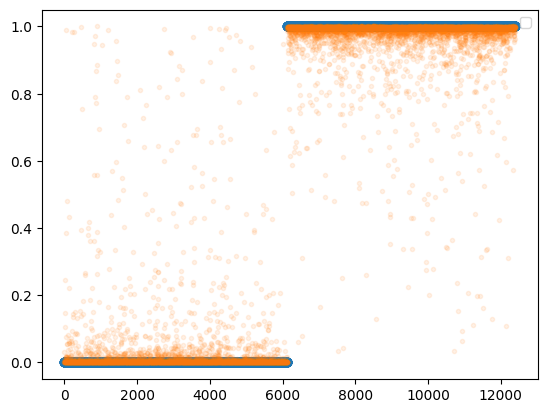

In [74]:
plt.plot(y,'o')
plt.plot(net(X).data,'.',alpha=0.1)
plt.legend()

In [75]:
((yhat.data > 0.5) == y).float().mean() # train_accuracy

## D. Test

In [86]:
XX3 = torch.stack([to_tensor(XXi) for XXi, yyi in test_dataset if yyi==3])
XX7 = torch.stack([to_tensor(XXi) for XXi, yyi in test_dataset if yyi==7])
XX = torch.concat([XX3,XX7],axis=0)
yy = torch.tensor([0.0]*len(XX3) + [1.0]*len(XX7))

In [87]:
XX.shape,yy.shape

In [88]:
XX = torch.stack([xxi.reshape(-1) for xxi in XX])
yy = yy.reshape(-1,1)

In [89]:
XX.shape,yy.shape

/tmp/ipykernel_9703/3947149177.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()

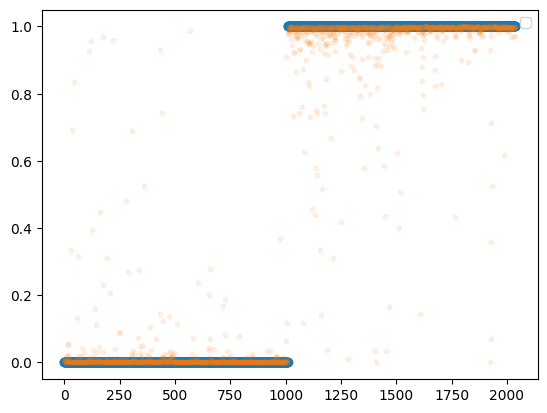

In [92]:
plt.plot(yy,'o')
plt.plot(net(XX).data,'.',alpha=0.1)
plt.legend()

In [93]:
(yy == (net(XX)>0.5)).float().mean() # test accuracy

Cybenko, George. 1989. “Approximation by Superpositions of a Sigmoidal
Function.” *Mathematics of Control, Signals and Systems* 2 (4): 303–14.

Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. 2016. *Deep
Learning*. MIT press.